<a href="https://colab.research.google.com/github/alexanet/From-PubMed-to-Pipeline/blob/main/PubMed_2Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Install dependencies (run this cell in Colab/Jupyter)

!pip install --upgrade pip
!pip install openai biopython pandas sentence-transformers faiss-cpu tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 116.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 49.0 MB/s  0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 30.1 MB/s  0:00:13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 57.9 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 55.4 MB/s  0:00:02
   ━━━━━━━━

In [2]:
!pip install -q transformers accelerate sentence-transformers faiss-cpu

In [3]:
!pip install torch

In [4]:
# ===========================================
# STEP 1 — Imports
# ===========================================
import requests
from xml.etree import ElementTree
import pandas as pd
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import faiss
from time import sleep


In [5]:
# ===========================================
# STEP 2 — Fetch PubMed abstracts via Entrez E-utilities
# ===========================================
def fetch_pubmed_abstracts(query, max_results=50, email="your_email@example.com"):  #Add your email here
    # Step 1: Search for PubMed IDs (PMIDs)
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": max_results,
        "retmode": "xml",
        "email": email
    }
    r = requests.get(search_url, params=params)
    root = ElementTree.fromstring(r.content)
    pmids = [id_elem.text for id_elem in root.findall(".//IdList/Id")]

    # Step 2: Fetch summaries for each PMID (title + abstract)
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    abstracts = []
    batch_size = 10
    for i in range(0, len(pmids), batch_size):
        batch_pmids = pmids[i:i+batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_pmids),
            "retmode": "xml",
            "email": email
        }
        resp = requests.get(fetch_url, params=fetch_params)
        root = ElementTree.fromstring(resp.content)
        for article in root.findall(".//PubmedArticle"):
            title = article.findtext(".//ArticleTitle")
            abstract_text = ""
            abstract_nodes = article.findall(".//AbstractText")
            if abstract_nodes:
                abstract_text = " ".join([node.text for node in abstract_nodes if node.text])
            abstracts.append({"title": title, "abstract": abstract_text})
        sleep(0.3)  # NCBI recommends a short pause between requests
    return pd.DataFrame(abstracts)
print ("this step is done")

this step is done


In [6]:
# ===========================================
# STEP 3-pre — Add your Hugging Face access Token
# ===========================================
from huggingface_hub import notebook_login

notebook_login()

In [7]:
# ===========================================
# STEP 3 — Load LLM pipeline (Hugging Face)
# ===========================================
model_name = "meta-llama/Llama-2-7b-chat-hf"  # or another free model
generator = pipeline(
    "text-generation",
    model=model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    max_new_tokens=512
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0


In [8]:
# ===========================================
# STEP 4 — Define relation extraction & summarization functions
# ===========================================
def extract_relations_llm(text):
    prompt = f"""
Extract biomedical entities (genes, diseases, drugs) and their relations from the text below.
Return JSON in the format:
[
  {{"entity1": "...", "entity2": "...", "relation": "..."}}
]

Text: {text}
"""
    result = generator(prompt, do_sample=False, temperature=0.0)
    return result[0]["generated_text"].replace(prompt, "").strip()

def summarize_llm(text):
    prompt = f"Summarize the following biomedical abstract in 2 sentences:\n\n{text}"
    result = generator(prompt, do_sample=False, temperature=0.0)
    return result[0]["generated_text"].replace(prompt, "").strip()


In [9]:
# ===========================================
# STEP 5 — Fetch real PubMed abstracts
# ===========================================
print("Fetching PubMed abstracts for query: cancer biomarker...")
df = fetch_pubmed_abstracts("cancer biomarker", max_results=50, email="your-email@example.com")
print(f"Fetched {len(df)} abstracts.")

# Drop rows with empty abstracts
df = df[df["abstract"].str.strip() != ""]


Fetching PubMed abstracts for query: cancer biomarker...
Fetched 50 abstracts.


In [10]:
# ===========================================
# STEP 6 — Run relation extraction & summarization (sample subset for speed)
# WARNING: LLM calls are slow, so limiting to first 10 for demo
# ===========================================
subset_df = df.head(10).copy()

print("Running LLM extraction and summarization (10 abstracts)...")
subset_df["relations"] = subset_df["abstract"].apply(extract_relations_llm)
subset_df["summary"] = subset_df["abstract"].apply(summarize_llm)

print(subset_df[["title", "summary", "relations"]])

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running LLM extraction and summarization (10 abstracts)...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

                                               title summary  \
0  Identification and validation of LDHA and SLC1...           
1  ADAR1-mediated RNA editing in breast cancer: m...           
2  Predicting anterior repositioning splint effic...           
3  NSABP FC-11: A phase II study of neratinib plu...           
4  Evaluation of cabotegravir plus rilpivirine in...           
5  Utility and Pitfalls of β-D-Glucan for Diagnos...           
6  Sortilin-1, Targeted by miR-146a, Regulates th...           
7  In Lower-Grade Gliomas, the SPARC Family Exace...           
8  Urine proteomics uncovers biomarker candidates...           
9  The role of TNF signaling pathway in post-stro...           

                                           relations  
0  Expected output:\n[\n  {"entity1": "Lactate de...  
1  Entities:\n\n* Breast cancer (BC)\n* Adenosine...  
2  Expected output:\n[\n  {"entity1": "genes", "e...  
3  Entities:\n\n* KRAS\n* metastatic colorectal c...  
4  Entities:\n\n* Ca

In [ ]:
# ===========================================
# STEP 6a — uncomment and run this step instead of step 6 if in the step 6 takes more than 15-20min
# ===========================================
# from concurrent.futures import ThreadPoolExecutor

# def process_paper(row):
#     relations = extract_relations_llm(row["abstract"])
#     summary = summarize_llm(row["abstract"])
#     return relations, summary

# with ThreadPoolExecutor(max_workers=3) as executor:
#     results = list(executor.map(process_paper, [row for _, row in subset_df.iterrows()]))

# subset_df["relations"], subset_df["summary"] = zip(*results)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [11]:
# ===========================================
# STEP 7 — Setup FAISS semantic search on full dataset
# ===========================================
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
abstract_embeddings = embedding_model.encode(df["abstract"].tolist())

d = abstract_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(abstract_embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
# ===========================================
# STEP 8 — Define semantic search function
# ===========================================
def search_abstracts(query, top_k=3):
    query_emb = embedding_model.encode([query])
    distances, indices = index.search(query_emb, top_k)
    return df.iloc[indices[0]][["title", "abstract"]]

print("\nSemantic Search for 'EGFR targeted therapy':")
print(search_abstracts("EGFR targeted therapy"))



Semantic Search for 'EGFR targeted therapy':
                                                title  \
47  The mechanism of ncRNA in trastuzumab resistan...   
15  FAM111B knockdown attenuates tumorigenesis of ...   
3   NSABP FC-11: A phase II study of neratinib plu...   

                                             abstract  
47  Human epidermal growth factor receptor-2 (HER2...  
15  Ovarian cancer, a prevalent malignancy with th...  
3   Patients with KRAS wild-type (wt) metastatic c...  


In [13]:
# ===========================================
# DONE — Save your enriched dataset
# ===========================================
subset_df.to_csv("pubmed_llm_enriched_subset.csv", index=False)
df.to_csv("pubmed_abstracts_full.csv", index=False)

print("\nAll done! Files saved.")


All done! Files saved.


In [14]:
# ===========================================
# Step 9 — Intractive dashboard
# ===========================================
!pip install -q gradio

import gradio as gr

def search_and_display(query):
    # Search top 5 abstracts
    results = search_abstracts(query, top_k=5)

    outputs = []
    for idx, row in results.iterrows():
        title = row["title"]
        abstract = row["abstract"]

        # Try to find enriched summary and relations from subset_df if available
        # (since summary & relations only for subset of 10 abstracts)
        enriched = subset_df[subset_df["title"] == title]
        if not enriched.empty:
            summary = enriched["summary"].values[0]
            relations = enriched["relations"].values[0]
        else:
            summary = "(No summary available)"
            relations = "(No relations extracted)"

        outputs.append(f"### {title}\n**Summary:** {summary}\n**Relations:** {relations}\n\n---\n")

    return "\n".join(outputs)

iface = gr.Interface(
    fn=search_and_display,
    inputs=gr.Textbox(label="Search PubMed abstracts"),
    outputs=gr.Markdown(label="Search Results"),
    title="PubMed Biomedical Abstracts Search + Relations",
    description="Search 50 PubMed abstracts on 'cancer biomarker' and see LLM-extracted summaries & relations."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://94e964d5a6a1c0c3fc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ===========================================
# Helper 1 — If you would like to check out the dataset
# ===========================================
from Bio import Entrez
import pandas as pd

# PubMed API setup
Entrez.email = "your_email@example.com" #Add your email here
query = "lung cancer biomarkers"
handle = Entrez.esearch(db="pubmed", term=query, retmax=5)
record = Entrez.read(handle)
ids = record["IdList"]

# Fetch abstracts
handle = Entrez.efetch(db="pubmed", id=ids, rettype="abstract", retmode="text")
abstracts = handle.read()

print("PubMed Query:", query)
print("="*60)
print(abstracts)


PubMed Query: lung cancer biomarkers
1. Thorac Cancer. 2025 Aug;16(15):e70129. doi: 10.1111/1759-7714.70129.

Sortilin-1, Targeted by miR-146a, Regulates the Behavior of Non-Small Cell Lung 
Cancer.

Lin X(1), Yan Z(2)(3)(4), Hai L(5)(6), Niu Y(3)(7), Wen JX(3)(7), Zhu HZ(2)(3), 
Yan C(2)(3), Cha SN(2)(3), Yan L(3)(8), Zheng WQ(2)(3), Zhang M(1)(9), Hu 
ZD(2)(3)(10).

Author information:
(1)Department of Thoracic Surgery, the Affiliated Hospital of Inner Mongolia 
Medical University, Hohhot, China.
(2)Department of Laboratory Medicine, the Affiliated Hospital of Inner Mongolia 
Medical University, Hohhot, China.
(3)Key Laboratory for Biomarkers, Inner Mongolia Medical University, Hohhot, 
China.
(4)School of Medical Laboratory, Tianjin Medical University, Tianjin, China.
(5)Department of Pathology, Basic Medical College, Inner Mongolia Medical 
University, Hohhot, China.
(6)Department of Pathology, the Affiliated Hospital of Inner Mongolia Medical 
University, Hohhot, China.
(7)Public 

Abstracts processed: 49
Manual time (low speed, 30/h): 1.63 h
Manual time (high speed, 70/h): 0.70 h
Prototype time: 1.00 h
Time saved range: 0.63–-0.30 h
Percent reduction: 38.8%–-42.9%


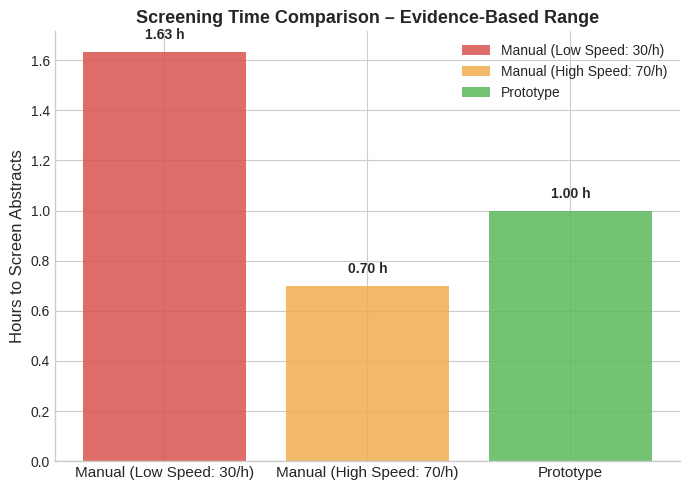

In [21]:
# ===========================================
# Helper 2 — Impact Metrics Visualization (Evidence-Based)
# ===========================================

import matplotlib.pyplot as plt
import numpy as np

# Evidence-based screening rates from Wallace et al. (2013)
low_speed = 30   # abstracts/hour (more complex screening)
high_speed = 70  # abstracts/hour (simpler screening)

abstracts_processed = len(df)  # adjust to subset_df if running demo

# Calculate manual times for both low/high speeds
manual_time_low = abstracts_processed / low_speed
manual_time_high = abstracts_processed / high_speed

# Prototype actual processing time (replace with measured time if known)
prototype_time = 1.0  # hours

# Calculate savings
time_saved_low = manual_time_low - prototype_time
time_saved_high = manual_time_high - prototype_time
pct_saved_low = (time_saved_low / manual_time_low) * 100
pct_saved_high = (time_saved_high / manual_time_high) * 100

# Print summary metrics
print(f"Abstracts processed: {abstracts_processed}")
print(f"Manual time (low speed, 30/h): {manual_time_low:.2f} h")
print(f"Manual time (high speed, 70/h): {manual_time_high:.2f} h")
print(f"Prototype time: {prototype_time:.2f} h")
print(f"Time saved range: {time_saved_low:.2f}–{time_saved_high:.2f} h")
print(f"Percent reduction: {pct_saved_low:.1f}%–{pct_saved_high:.1f}%")

# Visualization
fig, ax = plt.subplots(figsize=(7, 5))

bars = ["Manual (Low Speed: 30/h)", "Manual (High Speed: 70/h)", "Prototype"]
times = [manual_time_low, manual_time_high, prototype_time]
colors = ["#D9534F", "#F0AD4E", "#5CB85C"]

bar_positions = np.arange(len(bars))
ax.bar(bar_positions, times, color=colors, alpha=0.85, label=bars)

# Add labels
for i, v in enumerate(times):
    ax.text(i, v + 0.05, f"{v:.2f} h", ha="center", fontsize=10, fontweight='bold')

# Style settings
ax.set_xticks(bar_positions)
ax.set_xticklabels(bars, fontsize=11)
ax.set_ylabel("Hours to Screen Abstracts", fontsize=12)
ax.set_title("Screening Time Comparison – Evidence-Based Range", fontsize=13, fontweight='bold')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()